In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import datetime
import re 
import math
from sklearn import preprocessing
from dateutil import parser
import warnings
import imblearn
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Read csvs

train_df = pd.read_csv('/content/drive/Shareddrives/FML Kaggle/Data/train.csv', index_col=0)
test_df = pd.read_csv('/content/drive/Shareddrives/FML Kaggle/Data/test.csv', index_col=0)


In [ ]:
print('train_df shape: ',train_df.shape)
print('test_df shape: ',test_df.shape)


train_df shape:  (80176, 13)
test_df shape:  (34365, 12)


#1 Pre-processing

## 1.1 Process null values

In [ ]:
train_df.isnull().sum()

date                   0
org                 3451
tld                 3453
ccs                    0
bcced                  0
mail_type            172
images                 0
urls                   0
salutations            0
designation            0
chars_in_subject      16
chars_in_body          0
label                  0
dtype: int64

In [ ]:
test_df.isnull().sum()

date                   0
org                 1536
tld                 1536
ccs                    0
bcced                  0
mail_type             80
images                 0
urls                   0
salutations            0
designation            0
chars_in_subject       6
chars_in_body          0
dtype: int64

In [ ]:
train_df["org"]=train_df["org"].fillna('none')
train_df["tld"]=train_df["tld"].fillna('none')
train_df["mail_type"]=train_df["mail_type"].fillna('none')
train_df["chars_in_subject"]=train_df["chars_in_subject"].fillna(42) # the mean value

## 1.2 Check duplicates

In [ ]:
train_df[train_df.duplicated()==True].shape

# There are 10620 duplicate rows

(10620, 13)

In [ ]:
# here, we create a list to store the indices of duplicate records
list_temp = train_df.groupby(train_df.columns.tolist()).apply(lambda x: tuple(x.index)).tolist()
list_duplicate=list(filter(lambda s:len(s) >= 2,list_temp))
from itertools import chain
dup_list=list(chain(*list_duplicate))

In [ ]:
# create another dataframe to store deduplicated train set, let's see if dedupicating makes sense on prediction performance
train_df_no_dup=train_df.drop_duplicates()
train_df_no_dup.shape

(69556, 13)

In [ ]:
# we want to check if there are two rows with same values for all parameters while attached different labels

# we use train_df_no_dup here and then drop the column'lavel' for further detection of duplicates
train_df_temp_1=train_df_no_dup.drop(['label'],axis=1)
train_df_temp_1[train_df_temp_1.duplicated()==True].shape




(20416, 12)

There are 20416 rows of duplicate data, namely, they have same values for all parameters but with different labels attached. The amount is huge, We think there should be more information hidden by these duplicates, probably because we need more information to distinguish them or because they are ambiguous to be cateogrized into one single class.

In [ ]:
# group by all parameter columns and generate a list containing their indices
dup_ix_1 = train_df_temp_1.groupby(train_df_temp_1.columns.tolist()).apply(lambda x: tuple(x.index)).tolist()

# filter out those with length more than 1, which means they are duplicate
ln_1 = list(filter(lambda s:len(s) >= 2,dup_ix_1))
ln_1

[(10622, 51390),
 (13933, 45023),
 (30853, 41225),
 (32693, 71410),
 (55891, 74581),
 (73593, 77254),
 (27692, 63849),
 (448, 2093),
 (12349, 51373),
 (18259, 45535),
 (51939, 63865),
 (7878, 40473),
 (33806, 55436),
 (3335, 48511),
 (1377, 23877),
 (25489, 53961),
 (41916, 44419),
 (7662, 37583),
 (34567, 41414),
 (3936, 74802),
 (18580, 69866),
 (30966, 40203),
 (12941, 72518),
 (3681, 58536),
 (994, 47503),
 (46891, 53179),
 (8622, 46567),
 (26356, 47034),
 (12887, 37594),
 (39859, 77162),
 (62862, 67680),
 (38540, 65311),
 (22231, 25350),
 (15744, 63374),
 (48378, 54784),
 (34476, 72923),
 (998, 78031),
 (15211, 26033),
 (26324, 63024),
 (57190, 65483),
 (44588, 78668),
 (23570, 59134),
 (20652, 30978),
 (2702, 65022),
 (57235, 80087),
 (7083, 39098),
 (63630, 71654),
 (13318, 59318),
 (69914, 79266),
 (27822, 28537),
 (28313, 58229),
 (57991, 74440),
 (15280, 26090),
 (7277, 57903),
 (10055, 31147),
 (28012, 70491),
 (22092, 28778),
 (25038, 36378),
 (34028, 48945),
 (2511, 70450)

In [ ]:
ln_len=list(map(lambda i:len(i),ln_1))
from collections import Counter
Counter(ln_len)


# 19626 rows from original train set are duplicate twice, 395 rows are duplicate three times

Counter({2: 19626, 3: 395})

In [ ]:
# we can trace back to train_df via their indices
train_df.iloc[[725, 27760],:]

,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,label
725,"Fri, 22 Jul 2016 00:35:40 -0600",news,foodpanda.in,0,0,multipart/alternative,1,6,0,0,50.0,1220,1
27760,"Fri, 22 Jul 2016 00:35:40 -0600",news,foodpanda.in,0,0,multipart/alternative,1,6,0,0,50.0,1220,2


 We will add several dummy variables to store information given by these duplicate labels.

In [ ]:
 # Data preprocessing to deal with duplicates

#Concatinating the columns of the data frames to compare for duplicates
train_df['new'] =  train_df.iloc[:,:-1].apply(lambda x: ''.join(x.astype('str')), axis=1)
test_df['new'] =  test_df.iloc[:,:].apply(lambda x: ''.join(x.astype('str')), axis=1)

# Combining Train and Test Data
con_frames = pd.concat([train_df,test_df])

#Assigning a unique id to every duplicate
con_frames['new_id'] = con_frames.groupby('new').ngroup()

#Getting a list of counts of duplicates for every Duplicate ID
lst = con_frames['new_id'].value_counts()

#Dividing train and test again
df_dup_test = con_frames.iloc[80176:, :]
df_dup_train = con_frames.iloc[:80176,:]

# Assign the number of duplicates for each row
df_dup_train['count_dup'] = 0
for i in df_dup_train.index:
    if(lst[df_dup_train['new_id'][i]] > 1):
        df_dup_train['count_dup'][i] = lst[df_dup_train['new_id'][i]]
        
# Creating the label dict for the duplicates
label_dict = {}

# Each distinct new_id is associated with a list of labels
for i in df_dup_train.index:
    if(df_dup_train['count_dup'][i] > 0):
        if(df_dup_train['new_id'][i] in label_dict):
            label_dict[df_dup_train['new_id'][i]].add(int(df_dup_train['label'][i]))
        else:
            label_dict[df_dup_train['new_id'][i]] = set() 
            label_dict[df_dup_train['new_id'][i]].add(int(df_dup_train['label'][i]))
            
#Initializing the dummy variables
df_dup_train['0'] = 0
df_dup_train['1'] = 0
df_dup_train['2'] = 0
df_dup_train['3'] = 0
df_dup_train['4'] = 0
df_dup_train['5'] = 0
df_dup_train['6'] = 0
df_dup_train['7'] = 0

#Creating duplicate dummy varibales for Train data
for i in df_dup_train.index:
    if(df_dup_train['new_id'][i] in label_dict):
        #print(label_dict[df_dup_train['new_id'][i]])
        for j in label_dict[df_dup_train['new_id'][i]]:
            if(df_dup_train['label'][i]!= j ):
                df_dup_train[str(j)][i] = 1
                
#Assigning the duplicates from the duplicate dict
df_dup_test['count_dup'] = 0
for i in df_dup_test.index:
    if(lst[df_dup_test['new_id'][i]] > 1):
        df_dup_test['count_dup'][i] = lst[df_dup_test['new_id'][i]]
        
#Initializing the test data dummy variables
df_dup_test['0'] = 0
df_dup_test['1'] = 0
df_dup_test['2'] = 0
df_dup_test['3'] = 0
df_dup_test['4'] = 0
df_dup_test['5'] = 0
df_dup_test['6'] = 0
df_dup_test['7'] = 0

#Creating the duplicate dummy varibale for Test data
for i in df_dup_test.index:
    if(df_dup_test['new_id'][i] in label_dict):
        for j in label_dict[df_dup_test['new_id'][i]]:
            df_dup_test[str(j)][i] = 1
            
# Extract the dummy variables which are of interest for our training
df_dup_dummies_train = df_dup_train.iloc[:,-8:]
df_dup_dummies_test = df_dup_test.iloc[:,-8:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self

In [ ]:
train_df.drop(columns='new',inplace=True)

## 1.4 Check outliers

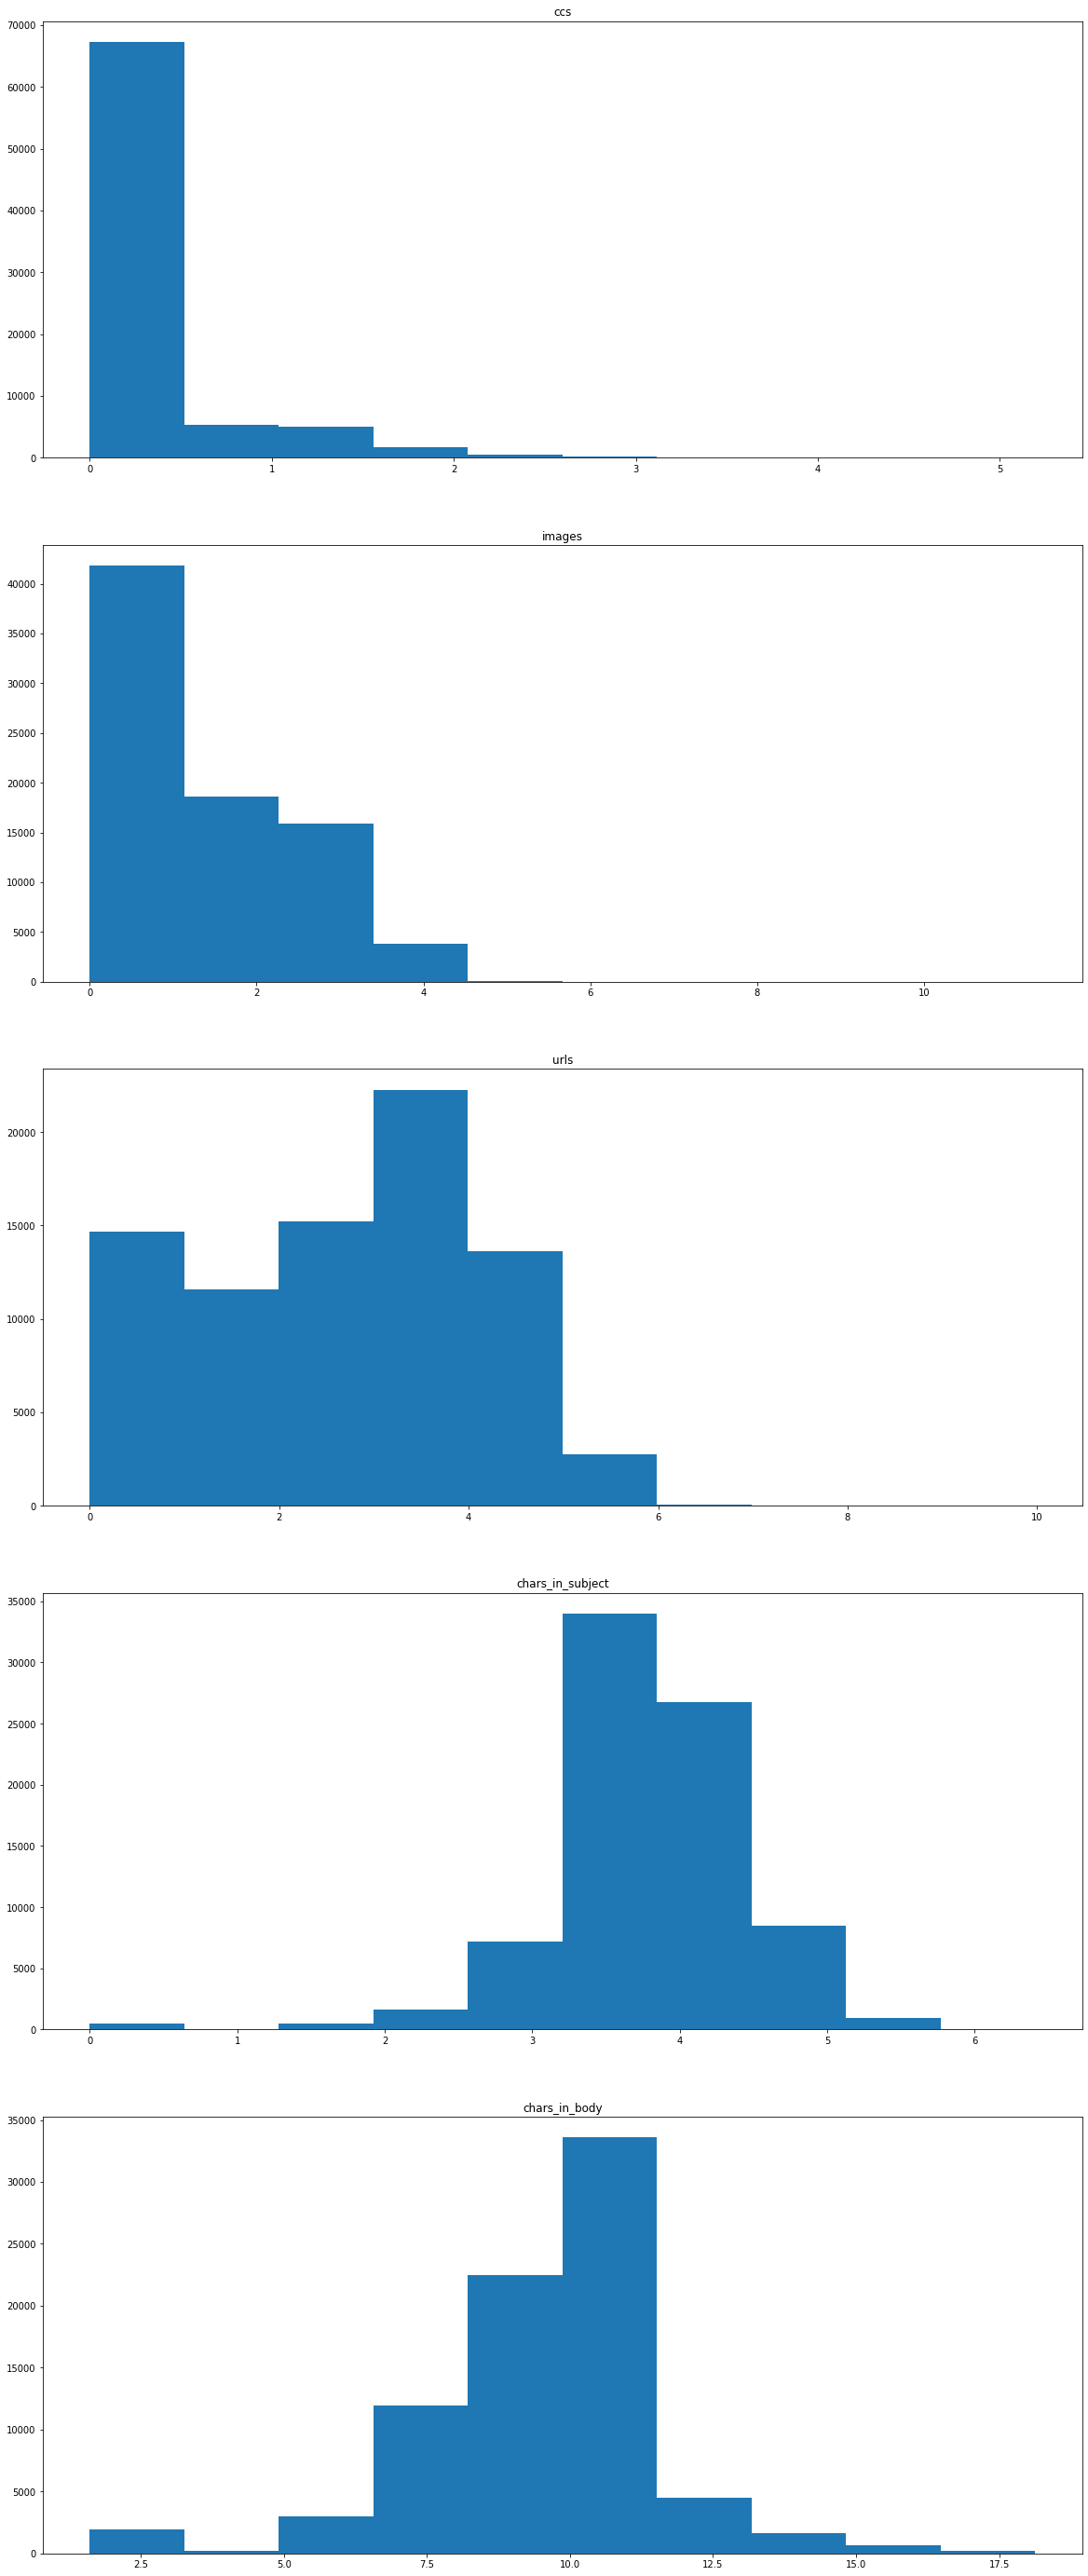

In [ ]:
# instead of checking their abosulte values, I used log here to make the outliers more significant
def check_outliers(df,num_features):
  fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(20,50))
  i=0
  for column in num_features:
      Xplot = np.log(df[column] + 1)
      
      ax[i].hist(Xplot)
      ax[i].set_title(column)
      i+=1

# plt.plot(np.arange(len(clean_train_df)), clean_train_df['images'])
# plt.show()

num_features=["ccs","images", "urls", "chars_in_subject", "chars_in_body"]
check_outliers(train_df,num_features) #

We can clearly see from the graph that there exist outliers. If we don't clean them, our models will be baised.

In [ ]:
def clean_outliers(df,num_features):

  for col in num_features:  
    q95=df[col].quantile(0.95) 
    df[col]=df[col].map(lambda x: x if x<q95 else q95)
  return df
num_features_1=['ccs','images', 'urls','chars_in_subject','chars_in_body']
clean_train_df=clean_outliers(train_df,num_features_1)
clean_train_df.shape

(80176, 14)

In [ ]:
clean_train_df.drop(columns='new',inplace=True)

In [ ]:
# we can check if outliers are removed
check_outliers(clean_train_df,num_features_1)

# we can clearly tell that the intervals of all numerical features are narrowed significantly, which is good.

NameError: ignored

# 2.Feature Engineering

## 2.1 Extract new features

### 2.1.1 Exploratory Analysis

In [ ]:
# Check unique value counts
clean_train_df.nunique()

date                47279
org                  1039
tld                   292
ccs                     4
bcced                   2
mail_type              14
images                 29
urls                  127
salutations             2
designation             2
chars_in_subject      118
chars_in_body       29540
label                   8
dtype: int64

In [ ]:
gb=clean_train_df.groupby('label') # there are in total 66302 rows
gb1=gb.get_group(1)
gb.get_group(1).describe() # label 1: personal network 
# --35446 rows (46.2%)，83% has no ccs，99.5% is not bcced,


,ccs,bcced,images,urls,salutations,designation,chars_in_subject,chars_in_body,label
count,37195.000000,37195.000000,37195.000000,37195.000000,37195.000000,37195.000000,37195.000000,37195.000000,37195.0
mean,0.301949,0.004571,5.063638,27.805511,0.447453,0.098884,45.963113,35275.961312,1.0
std,0.771073,0.067452,7.900209,35.616569,0.497238,0.298511,27.599069,47572.388877,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.0
25%,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,28.000000,3741.000000,1.0
50%,0.000000,0.000000,1.000000,14.000000,0.000000,0.000000,39.000000,17096.000000,1.0
75%,0.000000,0.000000,6.000000,37.000000,1.000000,0.000000,59.000000,42937.500000,1.0
max,3.000000,1.000000,28.000000,126.000000,1.000000,1.000000,117.000000,181107.000000,1.0


In [ ]:
c=('Updates','Personal','Promotions','Forums','purchases','Travel','Spam','Social')
gb_count=gb.count().date.to_frame()
gb_count['mail_type']=c
gb_count.columns=['count','mail_type']
gb_count

,count,mail_type
label,,
0,17995,Updates
1,37195,Personal
2,8567,Promotions
3,10727,Forums
4,357,purchases
5,141,Travel
6,152,Spam
7,5042,Social


In [ ]:
def bar_with_percentage_plot(x_list, y_list):
    plt.figure(figsize=(20,10))

    plt.bar(x_list, y_list, 0.4, color='b', alpha=0.8)

    plt.ylabel('count_percentage')
    plt.title('count by mail labels')
    max=y_list.max()
    y_max = max + max / 6
    plt.ylim([0, y_max])
    y_sum = sum(y_list)
    percentage = [x / y_sum for x in y_list]

    # add labels to each bar
    for x, y in enumerate(y_list):
       plt.text(x, y + y_max / 20, str(round(percentage[x], 4)), ha='center')
    plt.show()

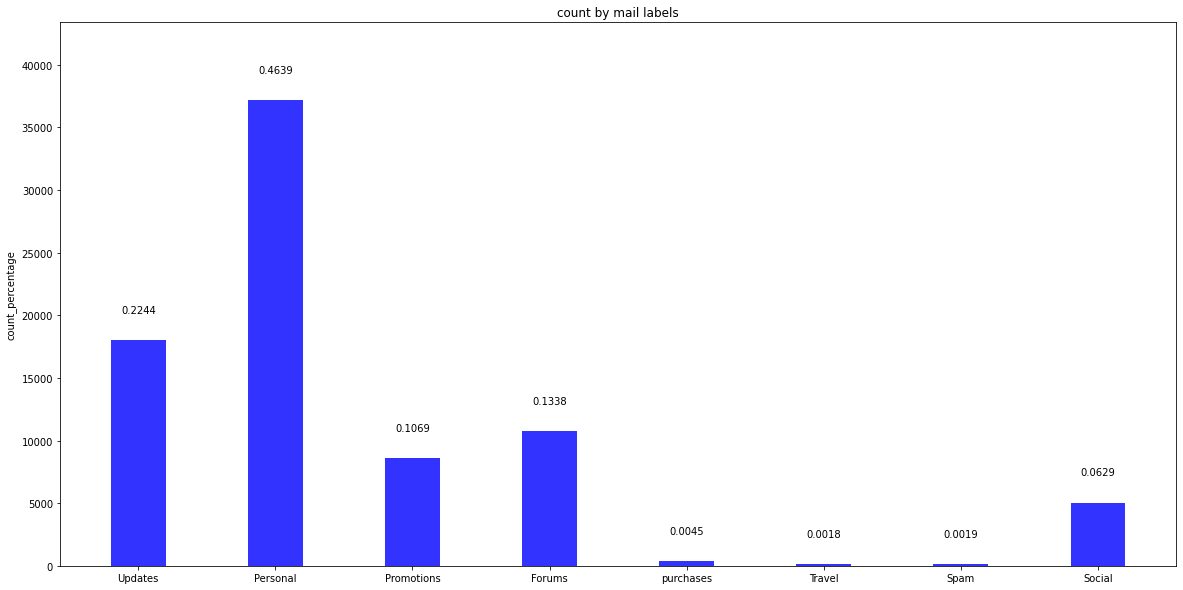

In [ ]:
bar_with_percentage_plot(gb_count['mail_type'],gb_count['count'])


### 2.1.2 Gathering more info from 'date'

#### 2.1.2.1 convert date column to datetime.datime


In [ ]:
type(clean_train_df['date'][1])

# For now, 'date' is stored as strings

str

In [ ]:
def date(date_string, i ):
    
    date_format = ['%a, %d %b %Y %H:%M:%S %z', '%d %b %Y %H:%M:%S %z', '%a, %d %b %Y %H:%M:%S', 
                  '%a, %d %b %Y %H:%M:%S %Z', '%d %b %Y %H:%M:%S']
    
    date_string = re.sub("[\(\[].*?[\)\]]", "", str(date_string)).rstrip()
    
    if date_string[-4:] == '0580':
        date_string = date_string[:-5].rstrip()
        
    x = None
    c = 0
    
    while x == None:
        
        try: 
            x = datetime.datetime.strptime(date_string, date_format[c])
            
            return x
        
        except ValueError:
            c += 1
            
            if c == len(date_format):
                
                x = i
                
                return x

In [ ]:
def append_date_time(df):
  # append a new column to store the processed date
  df.insert(df.shape[1], 'date_time', 0)

  list_date=df['date'].tolist()
  # create an empty list to store converted dates
  date_converted = []

  # Transform on train_df using date() function
  for i in range(len(list_date)):
    date_converted.append(date(list_date[i],str(i)))

  df['date_time']=date_converted
  #Drop those failed to be converted
  drop=[]
  for i in range(len(df)):
      if type(df['date_time'][i])!=datetime.datetime:
          drop.append(i)
  # df=df.drop(drop,axis=0)
  # # reset index
  # df.set_index(np.arange(len(df)), inplace=True)

  #drop original 'date'
  df.drop(columns='date',inplace=True)
  return df,drop,list_date

In [ ]:
clean_train_df,drop,list_date=append_date_time(clean_train_df)

In [ ]:
# example of why we have to drop the row where the date is not good, we can't convert them to datetime
# because we don't have sufficient information to know what is the real date
# source : https://stackoverflow.com/questions/43523370/date-format-conversion-from-cst-to-gmt-is-not-working
print('the indices of dropped rows:', drop)
print(list_date[42319])
print(list_date[68013])

the indices of dropped rows: [42319, 68013]
26 Dec 13 18:48:01
11-MAR-2018 20:40:58


In [ ]:
# we will manually fix them
from datetime import datetime as dt
date_time_str_1 = '26/12/13 18:48:01' 
date_time_obj_1 = dt.strptime(date_time_str_1,'%y/%m/%d %H:%M:%S')
date_time_str_2 = '11/03/18 20:40:58' 
date_time_obj_2 = dt.strptime(date_time_str_2,'%y/%m/%d %H:%M:%S')

In [ ]:
clean_train_df.loc[42319,'date_time']=date_time_obj_1
clean_train_df.loc[68013,'date_time']=date_time_obj_2

In [ ]:
clean_train_df.head(5)

,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,label,date_time
0,reply,ebay.in,0.0,0,multipart/alternative,28.0,120.0,0,0,49.0,80027.0,2,2017-11-06 11:13:45+01:00
1,edm,efinmail.com,0.0,0,multipart/alternative,1.0,7.0,0,0,107.0,2961.0,1,2018-02-14 11:00:16+00:00
2,usebackpack,com,0.0,0,text/html,4.0,17.0,0,0,35.0,25149.0,1,2016-07-06 19:53:37+00:00
3,granular,ai,0.0,0,multipart/mixed,0.0,0.0,0,0,15.0,181107.0,1,2019-10-11 11:25:40+02:00
4,github,com,1.0,0,multipart/alternative,2.0,11.0,0,0,49.0,2355.0,1,2017-11-07 11:07:18+00:00


#### 2.1.2.2 Extract detailed information from original 'date'

In [ ]:
def append_date(df):
  df.insert(df.shape[1], 'year', 0)
  df.insert(df.shape[1], 'month', 0)
  df.insert(df.shape[1], 'day_of_week', 0)
  # df.insert(df.shape[1], 'day_of_month', 0)
  df.insert(df.shape[1], 'hour', 0)
  df.insert(df.shape[1], 'timestamp', 0)
  for i in range(len(df)):
    df['year'][i] =  df['date_time'][i].year
    df['month'][i] =  df['date_time'][i].month
    df['hour'][i] =  df['date_time'][i].hour
    df['day_of_week'][i] = df['date_time'][i].weekday()
    # df['day_of_month'][i] = df['date_time'][i].strftime("%d")
    df['timestamp'][i] = int(round(df['date_time'][i].timestamp()))
  return df

In [ ]:
clean_train_df=append_date(clean_train_df)
clean_train_df.columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by Inte

Index(['org', 'tld', 'ccs', 'bcced', 'mail_type', 'images', 'urls',
       'salutations', 'designation', 'chars_in_subject', 'chars_in_body',
       'label', 'date_time', 'year', 'month', 'day_of_week', 'hour',
       'timestamp'],
      dtype='object')

### 2.1.3 Create binary variables

In [ ]:
def create_binary(df):
  
  # df["has_image"]=df["images"].map(lambda x:1 if x>0 else 0)
  # df["has_url"]=df["urls"].map(lambda x:1 if x>0 else 0)
  # df["has_char_in_subject"]=df["chars_in_subject"].map(lambda x:1 if x>0 else 0)
  # initially, we considered 'has_char_in_subject,'has_char_in_body'. however, because almost all rows have 1. we will skip it here.
  #df["has_char_in_body"]=df["chars_in_body"].map(lambda x:1 if x>0 else 0)

  #also, we could dig more into the time information
  df['if_weekend']= df["day_of_week"].map(lambda x:1 if x>=5 else 0)
  df['if_workinghours']= df["hour"].map(lambda x:1 if (x>=8 and x<=18) else 0)

  return df

In [ ]:
clean_train_df=create_binary(clean_train_df)
clean_train_df.columns

Index(['org', 'tld', 'ccs', 'bcced', 'mail_type', 'images', 'urls',
       'salutations', 'designation', 'chars_in_subject', 'chars_in_body',
       'label', 'date_time', 'year', 'month', 'day_of_week', 'hour',
       'timestamp', 'if_weekend', 'if_workinghours'],
      dtype='object')

### 2.1.4 Extract more features

In [ ]:
def extract_more(df):
  # firstly, we assume the length of a domain may count
  df['tld_len']=df["tld"].map(lambda x:len(str(x)))

  # then, we assume the ratio between 'chars_in_body' and 'images' may matter, because promotions tend to be lower in this ratio while those personal emails don't attach many images.
  # and we continue using log here to scale the amount
  df['bodychar_image_ratio']=np.log((df['images']/(1+df['chars_in_body']))+1)
  df['image_subject_ratio']=np.log((df['images']/(1+df['chars_in_subject']))+1)
  # following the same logic, we would add
  df['bodychar_url_ratio']=np.log((df['chars_in_body']/(1+df['urls']))+1)
  df['body_subject_ratio']=np.log((df['chars_in_body']/(1+df['chars_in_subject']))+1)
  df['url_subject_ratio']=np.log((df['urls']/(1+df['chars_in_subject']))+1)
  

  return df

In [ ]:
clean_train_df1=clean_train_df.copy(deep=True)
clean_train_df1=extract_more(clean_train_df1)
clean_train_df.columns

Index(['org', 'tld', 'ccs', 'bcced', 'mail_type', 'images', 'urls',
       'salutations', 'designation', 'chars_in_subject', 'chars_in_body',
       'label', 'date_time', 'year', 'month', 'day_of_week', 'hour',
       'timestamp', 'if_weekend', 'if_workinghours'],
      dtype='object')

## 2.2 Classify features into 3 types

In [ ]:
# In the last step, we will drop 'date_time' and categorize all features into 3 types.
# clean_train_df.drop(columns=['date_time'],inplace=True)
# clean_train_df1.drop(columns=['date_time'],inplace=True)
cate_features=["org","tld",'mail_type','year','month','day_of_week','hour'] 
num_features1=['ccs','images', 'urls','chars_in_subject','chars_in_body','tld_len',
       'bodychar_image_ratio', 'image_subject_ratio', 'bodychar_url_ratio',
       'body_subject_ratio', 'url_subject_ratio']
num_features=['ccs','images', 'urls','chars_in_subject','chars_in_body']
bi_features=["bcced",'salutations','designation','if_weekend','if_workinghours']

In [ ]:
# for column in bi_features:
#   print('in %s, we have:'%column)
#   print(clean_train_df[column].value_counts())

# from this result, we should drop 'has_char_in_body', cuz there is always 1

## 2.3 Normalizing numerical features

To remove the influence of different scales, we should normalize all numerical features. Plus, considering the existence of binary features, we'd better choose min-max normalization to cast all numerical features into [0,1].

In [ ]:
def normalization(df,num_features):
  for column in num_features:
    col=df[column]
    max=col.max()
    min=col.min()
    _range=max-min
    df[column]=(df[column]-min)/_range
    
  return df

In [ ]:
norm_train_df=normalization(clean_train_df,num_features)
norm_train_df1=normalization(clean_train_df1,num_features1)
norm_train_df.tail(5)


,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,label,year,month,day_of_week,hour,timestamp,if_weekend,if_workinghours
80171,github,com,0.333333,0,multipart/alternative,0.000000,0.063492,0,0,0.777778,0.007195,3,2020,6,1,5,1593521720,0,0
80172,none,none,0.000000,0,text/html,0.000000,0.015873,1,0,0.623932,0.074322,0,2015,5,4,11,1430461135,0,1
80173,google,com,0.000000,0,multipart/alternative,0.964286,0.674603,0,0,0.393162,0.157264,0,2020,5,1,8,1590506323,0,1
80174,medium,com,0.000000,0,multipart/alternative,1.000000,1.000000,1,1,1.000000,0.581282,0,2018,12,4,9,1544778073,0,1
80175,none,none,0.000000,0,multipart/alternative,0.000000,0.039683,0,0,1.000000,0.013600,0,2012,10,6,23,1350877429,1,0


In [ ]:
norm_train_df.shape

(80176, 27)

## 2.4 One hot encoding for categorical features

Before implementing one-hot encoding, we would like to give a closer look at categorical features, and check if any further processing work can be done.

### 2.4.1 Closer look at 'org' ,'tld'

Before applying one-hot, we would label those with low frequency as 'others'.

In [ ]:
clean_train_df['org'].value_counts()

iiitd           19943
usebackpack      5070
google           3890
none             3451
amazon           3123
                ...  
support             1
polimi              1
airtel              1
urekascience        1
zenysis             1
Name: org, Length: 1039, dtype: int64

In [ ]:
clean_train_df['tld'].value_counts()

com                     34619
ac.in                   20042
in                       3783
none                     3453
org                      3428
                        ...  
lumosity.com                1
technion.ac.il              1
assurance-maladie.fr        1
uu.nl                       1
stonybrook.edu              1
Name: tld, Length: 292, dtype: int64

In [ ]:
def process_org_tld(df,org_thres,tld_thres):
  
  org_map={}
  org_freq=df["org"].value_counts().to_dict()
  for k,v in org_freq.items():
      if v>org_thres:
          org_map[k]=k
  df["org"]=df["org"].map(lambda x:org_map.get(x,"others"))

          
  tld_map={}
  tld_freq=df["tld"].value_counts().to_dict()
  for k,v in tld_freq.items():
      if v>tld_thres:
          tld_map[k]=k 
  df["tld"]=df["tld"].map(lambda x:tld_map.get(x,"others"))

  
  return df

In [ ]:
# The threshold for org being 'others' is to have more than 100 observations 
# The threshold for tld being 'others' is to have more than 60 observations

processed_train_df=process_org_tld(clean_train_df,100,60)

In [ ]:
print('org has # of unique value:',len(processed_train_df['org'].unique()))
print('tld has # of unique value:',len(processed_train_df['tld'].unique()))


org has # of unique value: 94
tld has # of unique value: 51


### 2.4.2 Closer look at mail_type

In [ ]:
# mail_type
# we wanna check if any mail_type only has one label
dict1={}
for i in range(len(norm_train_df)):
  
  dict1.setdefault(norm_train_df.loc[i,'mail_type'],[]).append(norm_train_df.loc[i,'label'])
for k,v in dict1.items():
  if len(np.unique(v))<=1:
    print(k)


multipart/signed
multipart/report
text/calendar
multipart/IDM


In [ ]:
norm_train_df['mail_type'].value_counts()
# there are redundant values of mail_type, for example,multipart/alternative & Multipart/Alternative are the same,
# plus, there are some space in text/html.

multipart/alternative    58449
text/html                10224
multipart/mixed           6461
text/plain                2720
multipart/related         1996
none                       172
text/html                   58
Multipart/Mixed             39
multipart/signed            26
multipart/report            13
Text/Html                   10
text/calendar                4
Multipart/Alternative        3
multipart/IDM                1
Name: mail_type, dtype: int64

In [ ]:
norm_train_df1["mail_type"]=norm_train_df1["mail_type"].map(lambda x:str(x).lower().strip())

In [ ]:
norm_train_df.shape

(80176, 27)

### 2.4.3 one_hot()

In [ ]:
ohe=OneHotEncoder(sparse=False, drop ='if_binary')
# one-hot encoding
def one_hot(norm_train_df,cate_features):
  train_df_clean_cat=norm_train_df[cate_features].copy()
  clean_train_df_ohe=ohe.fit_transform(train_df_clean_cat)
  names=ohe.get_feature_names(cate_features)
  clean_train_df_ohe=pd.DataFrame(clean_train_df_ohe)
  clean_train_df_ohe.columns=names
  print('after one-hot encoding, we have: ',clean_train_df_ohe.shape, 'dataframe')
  norm_train_df_temp=norm_train_df.drop(columns=cate_features)
  train_df_temp=pd.concat([clean_train_df_ohe,norm_train_df_temp],axis=1)

  return train_df_temp

train_df_temp=one_hot(norm_train_df,cate_features)
train_df_temp.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


after one-hot encoding, we have:  (80176, 240) dataframe


(80176, 259)

## 2.5 Feature selection

In [ ]:
# we will filter out those features with low variance before entering next step
# from sklearn.feature_selection import VarianceThreshold
# def vt_selector(df, threshold=0.05):
#     selector = VarianceThreshold(threshold)
#     selector.fit(df)
#     return df[df.columns[selector.get_support(indices=True)]]
# train_ohe=vt_selector(clean_train_df_ohe)


# initially, we want to use variance threshold to filter out less significant features, however, in our case, because one-hot encoded features should be much sparse, so nearly 0 variance is quite normal
# hence, we switch to chi2 criterion
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

train_data=train_df_temp.drop(columns='label')
train_target=train_df_temp['label']
#return k best features
chi_res=SelectKBest(chi2, k=120).fit(train_data, train_target).get_feature_names_out()



In [ ]:
train_df_temp2=train_df_temp[chi_res]

In [ ]:
train_df_temp2=pd.concat([train_df_temp2,train_target],axis=1) #with 100 selected features


In [ ]:
train_df_temp.columns

Index(['org_126', 'org_aamaadmiparty', 'org_academia-mail', 'org_accounts',
       'org_airtable', 'org_amazon', 'org_angel', 'org_atcoder',
       'org_brilliant', 'org_centralesupelec',
       ...
       'has_image', 'has_url', 'if_weekend', 'if_workinghours', 'tld_len',
       'bodychar_image_ratio', 'image_subject_ratio', 'bodychar_url_ratio',
       'body_subject_ratio', 'url_subject_ratio'],
      dtype='object', length=259)

In [ ]:
train_df_temp2.columns


Index(['org_amazon', 'org_angel', 'org_centralesupelec', 'org_coursera',
       'org_duolingo', 'org_e', 'org_email', 'org_facebookmail',
       'org_flipkart', 'org_flipkartletters',
       ...
       'chars_in_body', 'has_image', 'has_url', 'if_weekend',
       'if_workinghours', 'tld_len', 'image_subject_ratio',
       'bodychar_url_ratio', 'url_subject_ratio', 'label'],
      dtype='object', length=121)

We could do further selection with the help of RFE, but after we tried with train_df_wrapped, we didn't see much improvement, hence we gave up on it.

In [ ]:
# Recursive feature elimination, https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html,
# the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. 
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression

# without_label=train_df_temp.drop(columns='label')
# rfe=RFE(estimator=LogisticRegression(), n_features_to_select=0.45)
# selector_rfe=rfe.fit_transform(without_label, train_df_temp['label'])


In [ ]:
# arr=rfe.get_support(indices=True)
# train_df_wrapped=pd.concat([train_df_temp.iloc[:,arr]],axis=1)
# train_df_wrapped=pd.concat([train_df_wrapped,train_df_temp['label']],axis=1)
# train_df_wrapped.columns

## 2.6 Processing on test set

Before implementing dimensionality reduction, we will transform test set here first.

In [ ]:
test_df = pd.read_csv('/content/drive/Shareddrives/FML Kaggle/Data/test.csv', index_col=0)

In [ ]:
np.mean(test_df['chars_in_subject'])

51.40274746063622

In [ ]:
test_df.shape

(34365, 12)

In [ ]:
# because we cannot simply drop the row which fails to be converted, so little adjustments is needed here
def append_date_time_1(df):
  df_1=df
  # append a new column to store the processed date
  df_1.insert(df.shape[1], 'date_time', 0)

  list_date=df_1['date'].tolist()
  # create an empty list to store converted dates
  date_converted = []

  # Transform on train_df using date() function
  for i in range(len(list_date)):
    date_converted.append(date(list_date[i],str(i)))

  df_1['date_time']=date_converted
  #Drop those failed to be converted
  drop=[]
  for i in range(len(df)):
      if type(df_1['date_time'][i])!=datetime.datetime:
          drop.append(i)
  #df=df.drop(drop,axis=0)
  # reset index
  #df.set_index(np.arange(len(df)), inplace=True)

  #drop original 'date'
  df_1.drop(columns='date',inplace=True)
  return df_1,drop

In [ ]:
test_df,drop=append_date_time_1(test_df)

In [ ]:
drop

[5898]

In [ ]:
origin_test_df = pd.read_csv('/content/drive/Shareddrives/FML Kaggle/Data/test.csv', index_col=0)

In [ ]:
origin_test_df.loc[5898,]

date                 11-MAR-2018 20:40:58
org                                   edc
tld                            bsnl.co.in
ccs                                     0
bcced                                   0
mail_type           multipart/alternative
images                                  1
urls                                    5
salutations                             1
designation                             0
chars_in_subject                       39
chars_in_body                        2817
Name: 5898, dtype: object

In [ ]:
from datetime import datetime as dt
date_time_str = '18/03/11 20:40:58' 
date_time_obj = dt.strptime(date_time_str,'%y/%m/%d %H:%M:%S')

In [ ]:
test_df.loc[5898,'date_time']=date_time_obj


In [ ]:
def process_test(test_df,train_df):

  # fill na values
  test_df["org"]=test_df["org"].fillna('none')
  test_df["tld"]=test_df["tld"].fillna('none')

  # process mail_type
  test_df["mail_type"]=test_df["mail_type"].fillna('none')
  test_df["mail_type"]=test_df["mail_type"].map(lambda x:str(x).lower().strip())
  
  test_df["chars_in_subject"]=test_df["chars_in_subject"].fillna(51.4)
  
  
  # Construct new features
  
  test_df=append_date(test_df)
  print('3',test_df.shape)
  test_df=create_binary(test_df)
  print('4',test_df.shape)
  test_df=extract_more(test_df)

  # Process org&tld
  test_df=process_org_tld(test_df,30,10)
  
  print('5',test_df.shape)
  # Drop useless columns
  test_df.drop(columns=['date_time'],inplace=True)

  # Deal with outliers, for those numerical features, replace those outside 95 quantile and null values with its 95 quantile
  clean_outliers(test_df,num_features)

  print('dealing with outliers done!')
  print(test_df.shape)
  #Normalize numerical features
  norm_test_df=normalization(test_df)

  print('normalization done!', norm_test_df.tail(5))
  print('3',test_df.shape)

  
  # One-hot encoding categorical features
  test_df_temp=one_hot(norm_test_df,cate_features)
  
  list_t=list(train_df.columns)
  list_t.remove('label')
  print(list_t)
  test_df_clean=test_df_temp[list_t]
  

  return test_df_clean


In [ ]:
def process_test_1(test_df,train_df):

  # fill na values
  test_df["org"]=test_df["org"].fillna('none')
  test_df["tld"]=test_df["tld"].fillna('none')

  # process mail_type
  test_df["mail_type"]=test_df["mail_type"].fillna('none')
  test_df["mail_type"]=test_df["mail_type"].map(lambda x:str(x).lower().strip())
  
  test_df["chars_in_subject"]=test_df["chars_in_subject"].fillna(51.4)
  
  
  # Construct new features
  
  test_df=append_date(test_df)
  print('3',test_df.shape)
  test_df=create_binary(test_df)
  print('4',test_df.shape)
  test_df=extract_more(test_df)

  # Process org&tld
  # test_df=process_org_tld(test_df,30,10)
  
  print('5',test_df.shape)
  # Drop useless columns
  test_df.drop(columns=['date_time'],inplace=True)

  # Deal with outliers, for those numerical features, replace those outside 95 quantile and null values with its 95 quantile
  clean_outliers(test_df,num_features1)

  print('dealing with outliers done!')
  print(test_df.shape)
  #Normalize numerical features
  norm_test_df=normalization(test_df,num_features)

  print('normalization done!', norm_test_df.tail(5))
  print('3',test_df.shape)

  
  # # One-hot encoding categorical features
  # test_df_temp=one_hot(norm_test_df,cate_features)
  
  # list_t=list(train_df.columns)
  # list_t.remove('label')
  # print(list_t)
  # test_df_clean=test_df_temp[list_t]
  

  return test_df


In [ ]:
test_df_02= test_df.copy(deep=True)
test_df_norm1=process_test_1(test_df_02,norm_train_df1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by Inte

3 (34365, 18)
4 (34365, 20)
5 (34365, 26)
dealing with outliers done!
(34365, 25)
normalization done!               org           tld  ...  body_subject_ratio  url_subject_ratio
34360       quora           com  ...            6.493418           0.595983
34361        shop  sdconnect.in  ...            6.127693           1.165507
34362       iiitd         ac.in  ...            4.848987           0.105361
34363  tatadocomo           com  ...            4.211177           0.143101
34364         crm  sdconnect.in  ...            5.414175           0.758286

[5 rows x 25 columns]
3 (34365, 25)


In [ ]:
test_df_01= test_df.copy(deep=True)
test_df_norm=process_test_1(test_df_01,norm_train_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by Inte

3 (34365, 18)
4 (34365, 20)
5 (34365, 20)
dealing with outliers done!
(34365, 19)
normalization done!               org           tld  ccs  ...   timestamp if_weekend  if_workinghours
34360       quora           com  0.0  ...  1474339613          0                0
34361        shop  sdconnect.in  0.0  ...  1471586747          0                0
34362       iiitd         ac.in  0.0  ...  1462361784          0                1
34363  tatadocomo           com  0.0  ...  1419843952          0                1
34364         crm  sdconnect.in  0.0  ...  1489904213          1                0

[5 rows x 19 columns]
3 (34365, 19)


In [ ]:
# We defined another process_test() without one-hot encoding
test_df_3= test_df.copy(deep=True)
test_df_norm=process_test_1(test_df_3,norm_train_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dis

3 (34365, 17)
4 (34365, 21)
5 (34365, 27)
dealing with outliers done!
(34365, 26)
normalization done!           org           tld  ...  body_subject_ratio  url_subject_ratio
34360   quora           com  ...            0.754711           0.461650
34361  others  sdconnect.in  ...            0.712028           0.902805
34362   iiitd         ac.in  ...            0.562795           0.081613
34363  others           com  ...            0.488359           0.110846
34364     crm  sdconnect.in  ...            0.628756           0.587371

[5 rows x 26 columns]
3 (34365, 26)


In [ ]:
train_df_temp.drop(columns=['year_2026', 'mail_type_text/calendar', 'year_2011'],inplace=True) #because these values don't exist in test_df

In [ ]:
test_df_1= test_df.copy(deep=True)
test_df_clean=process_test(test_df_1,train_df_temp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dis

3 (34365, 17)
4 (34365, 21)
5 (34365, 27)
dealing with outliers done!
(34365, 26)
normalization done!           org           tld  ...  body_subject_ratio  url_subject_ratio
34360   quora           com  ...            0.754711           0.461650
34361  others  sdconnect.in  ...            0.712028           0.902805
34362   iiitd         ac.in  ...            0.562795           0.081613
34363  others           com  ...            0.488359           0.110846
34364     crm  sdconnect.in  ...            0.628756           0.587371

[5 rows x 26 columns]
3 (34365, 26)
after one-hot encoding, we have:  (34365, 295) dataframe
['org_126', 'org_aamaadmiparty', 'org_academia-mail', 'org_accounts', 'org_airtable', 'org_amazon', 'org_angel', 'org_atcoder', 'org_brilliant', 'org_centralesupelec', 'org_change', 'org_cocubes', 'org_codechef', 'org_coursera', 'org_crazydomains', 'org_crm', 'org_discuss', 'org_duolingo', 'org_e', 'org_e-mail', 'org_edm', 'org_edx', 'org_email', 'org_entertainment', 'o

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
test_df_2= test_df.copy(deep=True)
test_df_clean2=process_test(test_df_2,train_df_temp2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dis

3 (34365, 17)
4 (34365, 21)
5 (34365, 27)
dealing with outliers done!
(34365, 26)
normalization done!           org           tld  ...  body_subject_ratio  url_subject_ratio
34360   quora           com  ...            0.754711           0.461650
34361  others  sdconnect.in  ...            0.712028           0.902805
34362   iiitd         ac.in  ...            0.562795           0.081613
34363  others           com  ...            0.488359           0.110846
34364     crm  sdconnect.in  ...            0.628756           0.587371

[5 rows x 26 columns]
3 (34365, 26)
after one-hot encoding, we have:  (34365, 295) dataframe
['org_amazon', 'org_angel', 'org_centralesupelec', 'org_coursera', 'org_duolingo', 'org_e', 'org_email', 'org_facebookmail', 'org_flipkart', 'org_flipkartletters', 'org_github', 'org_gmail', 'org_google', 'org_granular', 'org_ieee', 'org_iiitd', 'org_imdb', 'org_indiatimes', 'org_info', 'org_linkedin', 'org_mail', 'org_mailer', 'org_mails', 'org_marketing', 'org_medium'

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## 2.7 Dimensionality Reduction

In [ ]:
# Dimensionality reduction - PCA
data_test_np=np.nan_to_num(test_df_clean)
data_train_np=np.nan_to_num(train_df_temp.drop(columns='label'))

from sklearn.decomposition import PCA
# Keeping 90% of the variance
pca = PCA(n_components=0.9, svd_solver='full')
pca.fit(data_train_np)
data_train_pca = pca.transform(data_train_np)
data_test_pca = pca.transform(data_test_np)


In [ ]:
# Dimensionality reduction - LDA (Without PCA)

lda = LinearDiscriminantAnalysis()
y=train_df_temp['label']
#Using extracted label
lda.fit(data_train_np, y)
data_train_lda = lda.transform(data_train_np)
data_test_lda = lda.transform(data_test_np)

In [ ]:
# Dimensionality reduction - LDA (With PCA)

#lda = LinearDiscriminantAnalysis()

lda.fit(data_train_pca, y)
data_train_lda_pca = lda.transform(data_train_pca)
data_test_lda_pca = lda.transform(data_test_pca)


In [ ]:
list_label=['label_1','label_2','label_3','label_4','label_5','label_6','label_7','label_8']
df_dup_dummies_train.columns=list_label
df_dup_dummies_test.columns=list_label

In [ ]:
# dataframe with LDA
df_data_train_lda = pd.DataFrame(data_train_lda)
df_data_train_lda['label']=y
df_data_test_lda = pd.DataFrame(data_test_lda)

# dataframe with PCA
df_data_train_pca = pd.DataFrame(data_train_pca)
df_data_train_pca['label']=y
df_data_test_pca = pd.DataFrame(data_test_pca)

# dataframe with LDA and PCA
df_data_train_lda_pca = pd.DataFrame(data_train_lda_pca)
df_data_train_lda_pca['label']=y
df_data_test_lda_pca = pd.DataFrame(data_test_lda_pca)


In [ ]:
# Concatenate lda result with dummies for duplicates, in the format of dataframe

# with lda and pca
train_lda_pca = pd.concat([df_data_train_lda_pca, df_dup_dummies_train], axis=1)
test_lda_pca = pd.concat([df_data_test_lda_pca, df_dup_dummies_test], axis=1)

# with lda only
train_lda = pd.concat([df_data_train_lda, df_dup_dummies_train], axis=1)
test_lda = pd.concat([df_data_test_lda, df_dup_dummies_test], axis=1)

# with pca only
train_pca = pd.concat([df_data_train_pca, df_dup_dummies_train], axis=1)
test_pca = pd.concat([df_data_test_pca, df_dup_dummies_test], axis=1)

# without any dimensionality reduction
train_temp1 = pd.concat([train_df_temp, df_dup_dummies_train], axis=1)
test_temp1= pd.concat([test_df_clean, df_dup_dummies_test], axis=1)

train_temp2 = pd.concat([train_df_temp2, df_dup_dummies_train], axis=1)
test_temp2= pd.concat([test_df_clean2, df_dup_dummies_test], axis=1)

#without one-hot encoding and dimensionality reduction
train_norm = pd.concat([norm_train_df, df_dup_dummies_train], axis=1)
test_norm= pd.concat([test_df_norm, df_dup_dummies_test], axis=1)

# 3. Learning Algorithm

## 3.1 Split clean_train_df into train set and validation set

In [ ]:
from sklearn.model_selection import train_test_split
def split(df_name):
  without=df_name.drop(columns='label')
  x_train, x_test, y_train, y_test = train_test_split(without, df_name['label'] ,test_size=0.2, random_state=2)
  return x_train, x_test, y_train, y_test

Here, when training the model, we tried to fix the imbalance class issue with the help of SMOTE, which is a variant of oversampling method. Oversampling refers to copying or synthesizing new examples of the minority classes so that the number of examples in the minority class better resembles or matches the number of examples in the majority classes.

## 3.2 KNN 

In [ ]:
###### Best performing classifier

# Run grid search + cross validation to tune the hyperparameters of the KNN classifier
from sklearn.model_selection import GridSearchCV
grid_params = {
'n_neighbors': [3,5,11,20],
   'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

gs = GridSearchCV(KNeighborsClassifier(),grid_params, verbose = 10, cv =5, n_jobs = -1, scoring = 'f1_weighted', return_train_score = True)
#x_train, x_test, y_train, y_test = train_test_split_1(data_train_df)
#gs_results = gs.fit(x_train,y_train)

gs = GridSearchCV(KNeighborsClassifier(),grid_params, verbose = 10, cv =5, n_jobs = -1, scoring = 'f1_weighted', return_train_score = True)

#data_train_df=data_train_df.drop(['label'], axis = 1)
gs_results = gs.fit(train_lda_pca,y)

sorted(gs.cv_results_.keys())
print(gs.cv_results_['params'])
print(gs.cv_results_['mean_test_score']) # Mean test score to compare to mean train score for overfitting identification
print(gs.cv_results_['mean_train_score'])

gs.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


KeyboardInterrupt: ignored

In [ ]:
# Best KNN based on performed grid search : {'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'distance'}


clf = KNeighborsClassifier(metric = 'euclidean',n_neighbors = 20, weights = 'distance')


clf.fit(train_lda_pca.drop(columns='label'),y)
y_pred = clf.predict(test_lda_pca)

index = np.array([i for i in range(len(y_pred))], ndmin =2).T
y_pred_1 = np.array(y_pred, ndmin =2).T

final = np.concatenate((index, y_pred_1), axis=1)

np.savetxt('/content/drive/Shareddrives/FML Kaggle/Data/KNN_Result.csv', final, delimiter=',', header='ID,label',fmt='%i', comments = "")




/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


## 3.3 Random Forest

https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/

The RandomForestClassifier class in scikit-learn supports cost-sensitive learning via the “class_weight” argument.

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

rfc=RFC(random_state=42,n_estimators=100,max_features='auto',max_depth=8,criterion='entropy')
x_train, x_test, y_train, y_test=split(train_lda)
rfc.fit(x_train,y_train)
param_grid = { 
    'n_estimators': [80, 150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)

CV_rfc.best_params_



In [ ]:
# Predictions
pred=rfc.predict(x_test)

# Accuracy score
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred, labels=np.unique(train_df_temp['label'])))



## 3.4 Catboost

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [ ]:
# Now that catboost recommends us not to use one-hot encoding in preprocessing https://catboost.ai/en/docs/features/categorical-features
#, we should only try train_norm
x_train, x_test, y_train, y_test=split(norm_train_df1)

In [ ]:
from catboost import CatBoostClassifier, Pool
# from imblearn.over_sampling import SMOTE
# oversample=SMOTE()
# x_train,y_train=oversample.fit_resample(x_train,y_train)
#indicating categorical features
categorical_features_indices = np.where(x_train.dtypes != np.float)[0]
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)

# #actual model, the best parameters given by GridSearch 
#'params': {'depth': 9, 'iterations': 500, 'l2_leaf_reg': 1,'learning_rate': 0.2}}
cat = CatBoostClassifier(iterations=300)
                        #  , auto_class_weights='Balanced')

cat.fit(train_pool)



Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.270595
0:	learn: 1.4636765	total: 2.18s	remaining: 10m 51s
1:	learn: 1.2394233	total: 4.32s	remaining: 10m 44s
2:	learn: 1.1063754	total: 6.3s	remaining: 10m 23s
3:	learn: 1.0196747	total: 8.6s	remaining: 10m 36s
4:	learn: 0.9573826	total: 10.8s	remaining: 10m 37s
5:	learn: 0.9183449	total: 13.4s	remaining: 10m 58s
6:	learn: 0.8837164	total: 15.6s	remaining: 10m 50s
7:	learn: 0.8326053	total: 17.4s	remaining: 10m 33s
8:	learn: 0.8120512	total: 20.1s	remaining: 10m 50s
9:	learn: 0.7843903	total: 22.2s	remaining: 10m 42s
10:	learn: 0.7670211	total: 24.1s	remaining: 10m 33s
11:	learn: 0.7534643	total: 26.2s	remaining: 10m 27s
12:	learn: 0.7434412	total: 28.4s	remaining: 10m 26s
13:	learn: 0.7324926	total: 30.9s	remaining: 10m 30s
14:	learn: 0.7274120	total: 33.3s	remaining: 10m 31s
15:	learn: 0.7201306	total: 35.4s	remaining: 10m 27s
16:	learn: 0.7163367	total: 37.6s	remaining: 10m 25s
17:	learn: 0.7118640	total: 39.7s	remaining: 10m 22s
18:	learn: 0.7069170	total: 

In [ ]:
#hyperparameter tuning, grid search
from catboost import CatBoostClassifier, Pool
import catboost as cb
from sklearn.model_selection import KFold
from itertools import product,chain

# params_cat = {'depth':[3,1,2,6,4,5,7,8,9,10],
#           'iterations':[100,200,500],
#           'learning_rate':[0.03,0.05,0.01,0.1,0.2,0.3],
#           'l2_leaf_reg':[1,3,5,10,100]}
#indicating categorical features
categorical_features_indices = np.where(x_train.dtypes != np.float)[0]
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)

cat = CatBoostClassifier(one_hot_max_size=1500)

CV_cat = cat.grid_search(params_cat, train_pool, cv= 3)

CV_cat
#make prediction for evaluation

y_pred_cat = CV_cat.best_estimator_.predict(x_test)

In [ ]:
CV_cat

In [ ]:
#make prediction for evaluation
y_pred_cat = cat.predict(x_test)


# Accuracy score
print("Accuracy for Catboost on CV data: ",accuracy_score(y_test,y_pred_cat))

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_cat, labels=np.unique(norm_train_df['label'])))

# with class balance 0.724
# without balance parmeter 0.75

# extact more features 0.75

Accuracy for Catboost on CV data:  0.7500623596906959
              precision    recall  f1-score   support

           0       0.73      0.74      0.73      3700
           1       0.74      0.80      0.77      7299
           2       0.75      0.68      0.71      1735
           3       0.80      0.68      0.74      2110
           4       0.61      0.27      0.37        74
           5       0.28      0.29      0.29        17
           6       0.73      0.52      0.61        42
           7       0.80      0.79      0.80      1059

    accuracy                           0.75     16036
   macro avg       0.68      0.60      0.63     16036
weighted avg       0.75      0.75      0.75     16036



In [ ]:
cat.get_feature_importance(prettified=True)

,Feature Id,Importances
0,org,27.382959
1,year,12.358564
2,tld,8.927972
3,month,7.165528
4,timestamp,6.403977
5,hour,5.122257
6,chars_in_subject,4.652666
7,mail_type,4.102524
8,bodychar_url_ratio,3.773035
9,day_of_week,3.331148


In [ ]:
# train again on the entire train set
categorical_features_indices = np.where(x_train.dtypes != np.float)[0]
train_pool_total = Pool(norm_train_df1.drop(columns='label'), norm_train_df1['label'], cat_features=categorical_features_indices)

cat.fit(train_pool_total)


Learning rate set to 0.273692
0:	learn: 1.4407357	total: 2.28s	remaining: 11m 21s
1:	learn: 1.2163325	total: 5.05s	remaining: 12m 33s
2:	learn: 1.0840974	total: 7.9s	remaining: 13m 1s
3:	learn: 1.0013637	total: 11.1s	remaining: 13m 43s
4:	learn: 0.9462857	total: 14.1s	remaining: 13m 51s
5:	learn: 0.9034076	total: 16.9s	remaining: 13m 47s
6:	learn: 0.8404823	total: 18.9s	remaining: 13m 11s
7:	learn: 0.8000890	total: 21s	remaining: 12m 46s
8:	learn: 0.7734102	total: 23.1s	remaining: 12m 27s
9:	learn: 0.7544092	total: 25.5s	remaining: 12m 20s
10:	learn: 0.7412077	total: 27.9s	remaining: 12m 13s
11:	learn: 0.7265343	total: 30.7s	remaining: 12m 16s
12:	learn: 0.7170289	total: 34s	remaining: 12m 29s
13:	learn: 0.7117443	total: 36.2s	remaining: 12m 19s
14:	learn: 0.7028129	total: 39.3s	remaining: 12m 26s
15:	learn: 0.6917625	total: 41.6s	remaining: 12m 18s
16:	learn: 0.6841113	total: 44s	remaining: 12m 12s
17:	learn: 0.6795893	total: 47s	remaining: 12m 15s
18:	learn: 0.6707435	total: 50s	rema

## 3.5 SVM

In [ ]:
x_train_lda, x_val_lda, y_train_lda, y_val_lda = split(df_data_train_lda)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import svm

# try with data_train_smote dataset

# fitting the model to the training data
# using different kernel functions
# the penalty term C is set to 1.0 for all classifier
# decision function shape one-vs-one 'ovo'


# linear
linear_svm = svm.SVC(kernel='linear', C=70, 
                  decision_function_shape='ovo', gamma=0.02).fit(x_train_lda, y_train_lda)

# # radial basis function
# rbf_svm = svm.SVC(kernel='rbf', C=70, 
#                   decision_function_shape='ovo', gamma=0.02).fit(x_train_lda, y_train_lda)

# # polynomial
# poly_svm = svm.SVC(kernel='poly', C=70, 
#                   decision_function_shape='ovo', gamma=0.02).fit(x_train_lda, y_train_lda)

# # sigmoid
# sig_svm = svm.SVC(kernel='sigmoid', C=70, 
#                   decision_function_shape='ovo', gamma=0.02).fit(x_train_lda, y_train_lda)


In [ ]:
# predictions
linear_pred = linear_svm.predict(x_val_lda)
# rbf_pred = rbf_svm.predict(x_val_lda)
# poly_pred = poly_svm.predict(x_val_lda)
# sig_pred = sig_svm.predict(x_val_lda)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val_lda, linear_pred))

In [ ]:
# Compute accuracy rates using cross validation
# retrieve the accuracy and print it for all 4 kernel functions
from sklearn.model_selection import cross_val_score

accuracy_lin = cross_val_score(linear_svm, x_val_lda, y_val_lda, cv=4)
# accuracy_rbf = cross_val_score(rbf_svm, x_val_lda, y_val_lda, cv=4)
# accuracy_poly = cross_val_score(poly_svm, x_val_lda, y_val_lda, cv=4)
# accuracy_sig = cross_val_score(sig_svm, x_val_lda, y_val_lda, cv=4)

print("Accuracy Linear Kernel:", accuracy_lin)
print("Accuracy Radial Basis Kernel:", accuracy_rbf)
print("Accuracy Polynomial Kernel:", accuracy_poly)
print("Accuracy Sigmoid Kernel:", accuracy_sig)

In [ ]:
# creating a confusion matrix
# True Positives on the diagonal
# cm_lin = confusion_matrix(y_val_lda, linear_pred)
# cm_poly = confusion_matrix(y_val_lda, poly_pred)
# cm_rbf = confusion_matrix(y_val_lda, rbf_pred)
# cm_sig = confusion_matrix(y_val_lda, sig_pred)

print(cm_lin)
# print(cm_poly)
# print(cm_rbf)
# print(cm_sig)

In [ ]:
# # Tuning hyper-parameter
# from sklearn.model_selection import GridSearchCV

# # C:     ['linear', 'poly', 'rbf', 'sigmoid']
# # gamma: [1,0.1,0.01,0.001]

# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1],'kernel': ['linear']}

# # Create a GridSearchCV object and fit it to the training data
# grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=2, njobs=-1)

# grid.fit(x_train_lda,y_train_lda)

# # Print the optimal parameters
# print(grid.best_estimator_)

# # Take this grid model to create some predictions using the test set 

# # and then create classification reports and confusion matrices
# grid_predictions = grid.predict(x_test_lda)
# print(confusion_matrix(y_train_lda,grid_predictions))
# print(classification_report(y_train_lda,grid_predictions))#Output

In [ ]:
# Save results

# LDA df
pred_df = pd.DataFrame(y_pred_test_lda, columns=['label'])
pred_df.to_csv("svm_lda_sample_submission.csv", index=True, index_label='Id')

## 3.6 XGboost


### With LDA

In [ ]:
# Results GridSearchCV performed on the lda DataFrame
# Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500}
# Highest F1 score:  0.6986920332936979

In [ ]:
from xgboost import XGBClassifier
xgbclass_lda = XGBClassifier(colsample_bytree=0.7, learning_rate=0.05,max_depth=10, n_estimators=500, n_jobs=-1)
xgbclass_lda.fit(x_train_lda, y_train_lda)
y_pred_lda = xgbclass.predict(x_val_lda)

In [ ]:
from xgboost import XGBClassifier
xgbclass_lda = XGBClassifier().fit(x_train_lda, y_train_lda)
y_pred_lda = xgbclass_lda.predict(x_val_lda)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val_lda, y_pred)
print(cm)
accuracy_score(y_val_lda, y_pred)

### Without LDA and PCA

In [ ]:
xgbclass = XGBClassifier(colsample_bytree=0.7, learning_rate=0.05,max_depth=10, n_estimators=500, n_jobs=-1)
xgbclass.fit(x_train, y_train)

y_pred = xgbclass.predict(x_val)
cm = confusion_matrix(y_val, y_pred)
print(cm)
accuracy_score(y_val, y_pred)

### With PCA

In [ ]:
xgbclass_pca = XGBClassifier(colsample_bytree=0.7, learning_rate=0.05,max_depth=10, n_estimators=500, n_jobs=-1)
xgbclass_pca.fit(x_train_pca, y_train_pca)

y_pred = xgbclass_pca.predict(x_val_pca)
cm = confusion_matrix(y_val_pca, y_pred)
print(cm)
accuracy_score(y_val_pca, y_pred)

### Hyperparameters tuning using GridSearchCV

In [ ]:
# from sklearn.model_selection import GridSearchCV

# xgb = XGBClassifier()

# params = { 'max_depth': [3,6,10],
#            'learning_rate': [0.01, 0.05, 0.1],
#            'n_estimators': [100, 500, 1000],
#            'colsample_bytree': [0.3, 0.7]}

# xgbclf = GridSearchCV(estimator=xgb, 
#                    param_grid=params,
#                    scoring='f1_micro' , 
#                    verbose=2)

# xgbclf.fit(x_train_lda, y_train_lda)

# sorted(xgbclf.cv_results_.keys())
# print(xgbclf.cv_results_)
# print("Best parameters:", xgbclf.best_params_)
# print("Highest F1 score: ", xgbclf.best_score_)

### Predictions on the test set

In [ ]:
# Predictions
y_pred_test_lda = xgbclass_lda.predict(df_data_test_lda)
# y_pred_test = xgbclass.predict(df_data_test)
# y_pred_test_pca = xgbclass_pca.predict(df_data_test_pca)

In [ ]:
# Save results

# LDA df
pred_df = pd.DataFrame(y_pred_test_lda, columns=['label'])
pred_df.to_csv("xgb_lda_sample_submission.csv", index=True, index_label='Id')

# # Without LDA and PCA df
# pred_df = pd.DataFrame(y_pred_test, columns=['label'])
# pred_df.to_csv("xgb_sample_submission.csv", index=True, index_label='Id')

# # PCA df
# pred_df = pd.DataFrame(y_pred_test_pca, columns=['label'])
# pred_df.to_csv("xgb_sample_submission.csv", index=True, index_label='Id')

## 3.7 Naive Bayes

### Data without LDA or PCA

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

In [ ]:
GaussNB = GaussianNB()
GaussNB.fit(x_train_normal, y_train_normal)
print(GaussNB)

y_predict_naive_normal_gauss = GaussNB.predict(x_test_normal)
print(accuracy_score(y_test_normal, y_predict_naive_normal_gauss))

BernouNB = BernoulliNB()
BernouNB.fit(x_train_normal, y_train_normal)
print(BernouNB)

y_predict_naive_normal_bernoui = BernouNB.predict(x_test_normal)
print(accuracy_score(y_test_normal, y_predict_naive_normal_bernoui))


### Data with PCA

In [ ]:
GaussNB = GaussianNB()
GaussNB.fit(x_train_pca, y_train_pca)
print(GaussNB)

y_predict_naive_pca_gauss = GaussNB.predict(x_test_pca)
print(accuracy_score(y_test_pca, y_predict_naive_normal_gauss))

BernouNB = BernoulliNB()
BernouNB.fit(x_train_pca, y_train_pca)
print(BernouNB)

y_predict_naive_pca_bernoui = BernouNB.predict(x_test_pca)
print(accuracy_score(y_test_pca, y_predict_naive_pca_bernoui))


### Data with LDA

In [ ]:
GaussNB = GaussianNB()
GaussNB.fit(x_train_lda, y_train_lda)
print(GaussNB)

y_predict_naive_lda_gauss = GaussNB.predict(x_test_lda)
print(accuracy_score(y_test_lda, y_predict_naive_lda_gauss))

BernouNB = BernoulliNB()
BernouNB.fit(x_train_lda, y_train_lda)
print(BernouNB)

y_predict_naive_lda_bernoui = BernouNB.predict(x_test_lda)
print(accuracy_score(y_test_lda, y_predict_naive_lda_bernoui))


# Save results

In [ ]:
test_df_clean.shape

In [ ]:
train_df_clean_X.shape

In [ ]:
x_train.columns

Index(['org', 'tld', 'ccs', 'bcced', 'mail_type', 'images', 'urls',
       'salutations', 'designation', 'chars_in_subject', 'chars_in_body',
       'year', 'month', 'day_of_week', 'hour', 'timestamp', 'if_weekend',
       'if_workinghours', 'tld_len', 'bodychar_image_ratio',
       'image_subject_ratio', 'bodychar_url_ratio', 'body_subject_ratio',
       'url_subject_ratio'],
      dtype='object')

In [ ]:
test_df_norm1.drop(columns='new',inplace=True)

In [ ]:

pred_y = cat.predict(test_df_norm1)
pred_df = pd.DataFrame(pred_y, columns=['label'])
pred_df.to_csv("revamped_final.csv", index=True, index_label='Id')